# Real Estate Investment Opportunity Identification

In [ ]:
#ADD AN OUTLINE HERE!

In [1]:
#We start with importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys

import cv2 #to read images
import glob #to tell it what kind of files to read within the filepath, in this case .jpg's
import skvideo.io


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from tensorflow.keras.utils import to_categorical #np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [4]:
from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance

import math

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

from skimage.transform import resize   #for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips

## 1. Data Wrangling

Since the tool we are making is designed work from images ALONE, the wrangling phase is to get the images into the right format.
##############################

In [5]:
# Establish the path to read all of the images 

#Will use 80/20 split for training/testing, following Ahmed/Moustafa model study

#Training
path_training_flip = glob.glob('Houses Dataset/Training Set/Flip_Mixed_Training/Flip_Kitchen_Training/*.jpg')
path_training_noflip = glob.glob('Houses Dataset/Training Set/Dont Flip_Mixed_Training/Dont Flip_Kitchen_Training/*.jpg')

#lol wow so that last slash at the very end actually DOES matter!! it didn't work without it - was getting 'empty set' error
#but it won't tell you that here for some reason

#Testing
path_testing_flip = glob.glob('Houses Dataset/Testing Set/Flip_Mixed_Testing/Flip_Kitchen_Testing/*.jpg')
path_testing_noflip = glob.glob('Houses Dataset/Testing Set/Dont Flip_Mixed_Testing/Dont Flip_Kitchen_Testing/*.jpg')

#glob looks for all files/filepaths that follow/contain a specified pattern, using the *wild card, so here *.jpg!

In [ ]:
#sA innocent beginnings!:
#so just thought of something - the point for testing is IT'S supposed to tell us whether it thinks it should be a flip/
#not flip... so i was like then why are WE giving it the answer right off the bat!? but the thing is it doesn't realize
#we're telling it the answer. we're only doing this for our OWN purposes for organization to make it easy for ourselves/
#to see/compare ITS answers to the RIGHT answers!
#wait actually so... how does it work to tell you the 'accuracy' of the prediction at the end?
#like cuz you label the flip/not flip. so like is it just taking those images and tryna slap a label on and then
#comparing to your label? how does it not cheat/get bias? how does it do this?

## 2. Data Preprocessing

In [6]:
# Define a function that'll get each image ready for modeling / preprocess

def image_preprocessing(path):
    #so with this function we'll give it the filepath. in fact, amazingly, this is the ONLY argument required!!
    
    #empty list to store all finished, preprocessed images
    images = []

    #loop through all the path images, preprocessing each one
    #remember the path uses GLOB so it's only getting .jpg's in our case since that's what we defined/wildcarded. there should only be .jpg's in there anyway, but just in case!
    for i in path:
        #read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will be the same size
        img = cv2.resize(img, dsize = (32,32), interpolation=cv2.INTER_CUBIC) #changed from raghu's 70, 140
        #interpolation tells it how to "create new pixels" to make the image look smoother as you make it bigger, aka *FILL-IN* the gaps!!!
        #rather than just stretch the original pixels and risking "pixely" images
        #bicubic is the smoothest cuz it's curved/polynomial

        # Crop to remove excess of the images we don't need for modeling, like around the border/near the edges, unnecessary noise,
        #watermarks, text etc
        
        #okay so we just set the pic above to be 32 pixel width x 32 height
        #so now we're cropping it to be MIDDLE 28 x 28! basically, it starts @ pixel 2, in each dimension, then goes 28, to pixel 30!

        #y,x are the STARTING pixel location height, width address/coords
        #to START trim at / KEEP picture at, then h,w is THE ACTUAL DESIRED LENGTH OF THE PICTURE!!!
        #img = img[y:y+h, x:x+w] (#so if you're okay with STARTING AT 0, then ofc would just be img[y:h, x:w]!)
        #so we ofc keep the option open bc prob in MOST cases we wouldn't be starting at 0!/the edge!
        #so like this is setting the pixels we wanna KEEP! so let's say you've got 100x100 pixels, and you wanted to trim centered/evenly,
        #so that you take 20 pixels off the top and 20 pixels off each side - top,bottom,left, right; aka the *MIDDLE 60*!!!
        #so like you'd want pixels 20 thru *80*! thus, it'd be: img = img[20:60+20,...] aka 20:80!!!
        #so since/if (0,0) is top left, then this example of 0,100,0,70 will keep only TOP 100 pixels of 140 and
        #chop off BOTTOM 40!! but he's okay w/ keeping ALL the width
        
        #SO THE y & x ARE THE *STARTING* y,x pixel point you wanna begin crop at/start keeping at!!!
        #then of course the h & w are actual height and width in pixels, so to get the right crop you gotta treat like
        #this,- algebraically/addressly/plotly, so that, say you want the new cropped pic to be only the MIDDLE 100
        #vertical pixels in heighth, out of 140 original, then you gotta START AT 20, then "ADD" 100 to represent the
        #desired image size, which'll take it to 120,-> THE DESIRED END LENGTH PIXEL LOCATION!!!
        
        ####QUESTION???####
        
        
        #the way they do it is starting pixel & number of pixels to go from there, aka the DESIRED PIXEL LENGTH!
        y,h,x,w = 2,28,2,28
        img = img[y:y+h, x:x+w]
        
        # Adjust brightness, contrast
        alpha=1.5 #contrast/gain
        beta=0.5  #brightness/bias
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        #addWeighted helps to blend/transition two images together, by specifiying respective weights, like how visible
        #or transparent one is
        #the np.zeros thing is the 2nd image?? it's creating an image of 0 size and 0 dtype? what's 0 dtype?
        #is this just a way of creating a 'blank' image to make it
        #then what is 0?? the template is:
        #cv.addWeighted(image1, alpha, image2, beta, gamma[, dst[, dtype]]) #note this is cv and not cv2... any difference?
        #this is confusing cuz the *0* is in the BETA spot and BETA is in the GAMMA spot! mistake??
        #also more confusing cuz alpha & beta here are the respective WEIGHTS to give to each image
        #whereas above it had to do w/ contrast & brightness?
        #and also, it seems like for image2 we're creating a 'blank' image, which we're further giving 0 weight...
        #which poses the question - why even bother doing a blend if we're not blending?? we're only using the first
        #image by itself! well maybe we're blending an image with a blank image to attempt to create a picture with a
        #'transparent' background, like those png images! to remove any excess / nonessential background noise around the
        #main part / meat of the picture?
        #but also, shouldn't alpha & beta be on a scale of 0 to 1 and sum to 1?? Or actually, I guess you could look at
        #it as each one can be an independent percentage transparency of its full resolution, so they can both be 1
        #for example and so don't necess have to add up to 1... BUT they DO both still need to be some RATIO / can't
        #be more than 1! but alpha is 1.5??
        
        
        
        ####QUESTIONS???!!!####

        
        
        
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        
        #this would be an important step in applications where color is irrelevant and it's just noise and you wanna focus
        #on the features. but in our application, REAL ESTATE, color is definitely very important. like if the floors are
        #modern gray, that property will def have more value
        
        img = cv2.bitwise_not(img)  #can look up this function later
        img = img/255               #and can look up why divide by 255 >> TO REDUCE ALL THE PIXEL COLOR VALUES
        #(described by a set of 3 numbers) TO BETWEEN 0 & 1!!! CUZ THE COLOR RATING/VALUE RANGE IS FROM 0 TO 255!!!
        #ORIGINALLY I THOUGHT THIS WAS DIVIDING BY 255 TO GET EVERYTHING IN GRAYSCALE LOL SO I COMMENTED OUT!!

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

#okay so overall, this is iterating thru our images in our path folder and reshaping/resizing/recoloring them and
#tryna crop out the background noise as much as possible?

In [7]:
# Read and preprocess the training data

#so in his example/template, he's classifying diff scenarios - pages to flip and pages that shouldn't be flipped
#what am I doing?  well, i guess in a way, I'M deciding whether to FLIP or not too.... A PROPERTY!!!
#so that means I needa manually sort thru each set of pics and train it based on which houses I want renovated and
#which ones I want as is
#so gotta fine/re-tune the objective/purpose/goal here. cuz we could make it like that^, or we could do more closely
#to what we were initially thinking, which is more like the Big Mountain project, and is what the creators of the
#parent dataset project i'm using did - just take ALL the data, split randomly, and use those to train factors to come
#up with the predicted price? oh but then we'd need text data - we'd have to have baseline prices
#i'm tryna remember how we did it in Big Mountain - we had prices, and then i think: found the most important factors
#that influenced the prices, and then accordingly used those to PREDICT what prices SHOULD be, based off what everyone
#else was doing. Similarly, this Ahmed/Moustafa project was for HOUSE PRICE ESTIMATION based off images AND text/numerical
#data both!

#but I was told it gets tricky when you try to do both, even though that makes more sense - that's obviously how a human
#would work, but to do that w/ computers takes advanced neural networking / deep learning etc and I'm not quite at that
#point yet. So, we'll simplify and use images alone! that's why this makes sense that we would have to do CATEGORIES then-
#because this is traditionally used as/or at least one very common/famous example/use of this is for CLASSIFICATION!
#so basically, image/face recognition like Apple's FaceID & furry friends & laying out all the 'people' in/from your pictures
#so you can quickly go to the pictures w/ them! and of course the first famous one that i knew - Facebook's facial recognition
#for tagging suggestions where they look at your pictures, look at the faces in them, and cross ref w/ your friends'
#pictures to get matches (lol what if your friend only has like a dog / only ever has dogs as their profile pic - no humans
#so that anytime you have a dog in your pic it suggests that it's that person! >v<)
#so yeah, then if we're only doing images, we don't have any prices to train it on, we can only pre-break it up and feed
#it what's what - so what properties should be:
#Renovated/Flipped - ones that are in poorer condition


#would be great to learn how to do both images and text so we can look at/consider other factors like neighborhood etc!
#and look at the asking price, come up with a predicted ACTUAL selling price, and then estimate calculations for the cost
#of renovating and the potential PROFIT MARK-UP / PRICE WE CAN SELL IT AT ONCE WE RENOVATE!! and also give the price
#we can get if we decide to RENT IT OUT!!! and then of course provide an accompanying report of like a cash flow/RoR
#analysis!!! It may be a slightly different algorithm for rental properties as far as like what costs go into it cuz
#may not spend on the same things cuz renovating for different purposes/diff audience. completely diff cash recovery/return
#method. so the cash flow obviously will look completely diff, diff costs etc
#so in that ideal scenario, the categories could be like: Renovate-Flip To Sell, Renovate-Flip To Rent,
#Buy-As-Is=>>TURNKEY To Rent, or Pass
#(could even have it look for rental properties you wanna renovate and SELL and not rent out yourself!)
#factor in whether to pay cash or finance

#but for now, we'll keep it / start off simple and just classify as Renovate/Flip or Pass/Not Flip


#HMMMmmmm, but now that i look more closely at this dataset I have, these are almost all NICE houses that are ready to
#go and wouldn't be candidates for flipping. and these are all sfh's i believe so may not have alot of options for renting
#either, unless there are some small ones. but again, identifying / subclassifying for renting is outside of the
#scope of this most likely since we don't have text data to tell us what's a multi fam vs. a condo etc and don't have
#the square footage and 'num of dwellings' to support that

#################################################################################################################################
#SO - that may mean that i need to MANUALLY collect/develop/compile my OWN database of images!!!! both for training and testing purposes
#################################################################################################################################


####QUESTION!!!####
#In image machine learning, do we also train it on what does NOT constitute a category, so that it doesn't get confused
#by other things/special/rare circumstances it might occur and knows how to handle it?
#YES!! that's what the NOT_FLIP is for!!
#for example, with real estate, in general we'll teach it to look for stuff that's outdated, based on style and color
#(and oftentimes even low image quality alone will indicate a bad situation i.e. a GOOD opportunity to renovate/flip
#but i guess it wouldn't matter too much cuz would still needa base on elements of image). also ARRANGEMENT - like if
#things are messy/in disarray. but what about if it encounters stuff that, technically, yes, is outdated, but it's in
#SEVERE disrepair, abandoned! how will / do we teach it to NOT classify those as investment opportunities / flips but
#rather as Do Not Buy's!
#so we may need to stick to just one kind of property, i.e. single family homes, and not do like condos or townhomes
#if we're factoring in the EXTERIOR of buildings cuz that would proabably throw it off and would be better to keep those
#all separate at first and then combine / aggregate later
#BUT - we COULD use ONLY interior pictures, in which case it wouldn't matter if it's a SFH, townhome or condo - and
#actually that makes more sense to only use interior bc that's the MAIN BASIS for deciding whether something is a good
#flip or not because that's the MAIN DRIVER of price in people's minds. cuz think about it - in a condo highrise or
#townhome village, - the exterior is shared/identical! so what sets them apart that can drastically alter price!?
#(other than possibly view) >> interior design!!!


#img_training = image_preprocessing(path = path_training_flip)
#Don't need to write path since that's the only arg / in general don't need if following/aligned w/ order
#deleted the remainder originals - all like this

# Read the training not flip

img_training_flip = image_preprocessing(path_training_flip)

# Read the training not flip

img_training_noflip = image_preprocessing(path_training_noflip)

# Read the test flip

img_testing_flip = image_preprocessing(path_testing_flip)

# Read the test not flip

img_testing_noflip = image_preprocessing(path_testing_noflip)



In [8]:
# Set the labels

#so this will output 1 for EVERY element in the folder?? the label is just gonna be 1 for each element?
#and what is the y representing anyway?
#ohhh, wait, think i got it. so we wanna train this thing to know when to flip and when not to flip, so "DO flip"
#is 1, aka TRUE!!! and don't is 0, seen below
#so we're assigning a value of 1/True for EVERY item in the training
#i have to look back at Big Mountain but i think we used labels when we were labeling the points as/w/ the state names
#but here the label also represents the value

#im a little confused on doing it for the testing set tho? again gotta look at Big Mountain but why are we assigning its
#values? isn't the point that we're supposed to SEE how well it does, like it SHOULD result in 1's for flips and 0's
#for nonflips... so maybe it's just gonna use these as benchmarks of what they SHOULD/'VE BEEN so we can see how the
#actuals compare to these shoulds/ideals/theoreticals
y_train_flip = [1 for i in range(0, len(img_training_flip))]

y_train_noflip = [0 for i in range(0, len(img_training_noflip))]

y_test_flip = [1 for i in range(0, len(img_testing_flip))]

y_test_noflip = [0 for i in range(0, len(img_testing_noflip))]

## 3. Modeling

In [9]:
# Define the X_train, X_test, y_train and y_test for analysis

#hmm okay, so the X's are the images themselves, interesting! that's all there is to it - can summarize all of it
#to simply that!
#and the y's are what we saw before/above - 1's & 0's accordingly
#and as we see, combine/unsegregate the flips/notflips into one! cuz together they still make up the training/testing sets

#Note the difference b/w concat & append! concat defaults to stacking VERTICALLY -> axis = 0
#and append defaults to FLATTENING COMPLETELY -> fully unraveling / stretching / connecting / daisy-chaining
#ALL rows out to ONE SINGLE LONG ROW!!!

#can do any kind of 3 stackings w/ either, but best to go w/ one who has what you're looking for as the default
#so that's why we use concat for X, cuz we want those vertically stacked,
#whereas we want our y's as one single long row
#... wait WHY THO????
#so for the X's, the flips & non-flips images will be two separate rows
#for the y's, the flips & non-flips VALUES will be ONE SINGLE ROW!
#question is - which direction are img_ & train_flip orientated?? which way does append naturally stack?
#okay, so i did a basic append using an empty list, which is what it seems they did w/ image_processing, and it
#APPENDS SIDEWAYS!!! horizontal/across/left-to-right. so then our hunch was right - concatting 2 X lists of images - those
#lists are each sideways (as opposed to upright; they're 'supine' lol), so when we concat w/ axis=0, they'll be stacked
#vertically, rowswise, so yes, each of these new X vars will be 2 rows, one flip one nonflip
#okay and then checked for y's by doing a practice list comprehension and that ALSO created a sideways/-wise list!
#thus, appending two y lists on axis None will make one longe list/row!!! and actually, didn't even need to practice
#check cuz anytime doing axis None for either (concat or append), it'll first AUTOMATICALLY FLATTEN the composite
#lists regardless of orientation! so that way it can just daisy-chain them together!
#so not sure if there's a reason *WHY* both are oriented horizontal, but maybe that's the key point - maybe it's not
#that they have to be oriented one way or the other, as long as they're oriented the SAME direction!


#####QUESTION#####

#X's are two rows
X_train = np.concatenate((img_training_flip, img_training_noflip))#, axis = 0) #default axis is already 0!!!

X_test = np.concatenate((img_testing_flip, img_testing_noflip))#, axis = 0) #can leave for emphasis/making it clear

#y's are one long row
y_train = np.append(y_train_flip, y_train_noflip)#, axis = None)

y_test = np.append(y_test_flip, y_test_noflip)#, axis = None)

In [10]:
# See if the shapes match between the X_train and y_train and the X_test and y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#okay so 462 for training bc we got 253 items for flip & 209 for don't flip
#BUT WHAT THE HECK IS THE 100, 70, 3????
#isn't it only even possible for the shape to be 2-dimensional???
#or at least, isn't that what it is here, since it's two rows??
#and/but actually it's a little confusing cuz the two rows have diff num of columns
#cuz first row is flip, which has more images than non-flip - so don't know if that causes issues?
#not sure how Raghu's was divided between flip/not flip. but his also shows the 100, 70, 3
#and it shows that for both training and testing???
# and we got 123 items for testing bc we got 72 items for flip & 51 for don't flip

(133, 28, 28, 3)
(133,)
(47, 28, 28, 3)
(47,)


In [11]:
#oh yeah bruh! why don't we just see what these arrays even look like now that we have them/can!!
X_train

array([[[[0.7254902 , 0.56862745, 0.34901961],
         [0.61568627, 0.45490196, 0.25490196],
         [0.74509804, 0.54509804, 0.29019608],
         ...,
         [0.76862745, 0.63137255, 0.4745098 ],
         [0.80392157, 0.6745098 , 0.4627451 ],
         [0.40392157, 0.25098039, 0.03921569]],

        [[0.59607843, 0.43137255, 0.23137255],
         [0.82745098, 0.67843137, 0.4745098 ],
         [0.66666667, 0.53333333, 0.34509804],
         ...,
         [0.61960784, 0.41568627, 0.18039216],
         [0.78431373, 0.63137255, 0.35686275],
         [0.34117647, 0.20784314, 0.        ]],

        [[0.44313725, 0.2745098 , 0.09019608],
         [0.6745098 , 0.49019608, 0.24313725],
         [0.81568627, 0.70196078, 0.45098039],
         ...,
         [0.50196078, 0.33333333, 0.10196078],
         [0.71372549, 0.58039216, 0.28627451],
         [0.64705882, 0.4745098 , 0.20784314]],

        ...,

        [[0.8627451 , 0.71372549, 0.49803922],
         [0.83137255, 0.70980392, 0.48627451]

In [12]:
#hmm interesting... so that's why the shape is so complicated lol? the shape i guess isn't simply the rows & columns
#w/ an array
#like np.shape([[1, 3]]) >> (1, 2) bc there's one [list] with 2 elements
#np.shape(np.array([(1, 2), (3, 4), (5, 6)]) >> (3,) bc it's 3 comma'd elements, but why no 1?....

#okay so the numpy array shape is: (#dimensions, #elements in that dimension)
#so each set of brackets is a dimension
#so X(_train) has 462 images, so each one is a bracketed set, then each of those has a 70x3 list-of-lists, i.e. 70
#bracketed sets, 3 elements each. this must have something to do w/ the image processing where this is how it
#transcribes images as numerical data structures - must be based on the image size/number of pixels we specified which
#is why it'd be the same in his data set and mine!!
#prob gotta adjust the image size!!! based on what's appropriate given my image sizes
#it could be that each set of 3 is THE COLOR PROFILE FOR ONE PIXEL!!! must be cuz you can see all the 255's which
#represent black i believe!!! (we divided by 255 earlier to convert each pixel's color component value to scale b/w 0 & 1!)
#AHHH OKAY YES!!! SO WE SPECIFIED IN THE IMAGE_PREPROCESSING TO MAKE THE HEIGHT AND WIDTH OF EACH PICTURE 100 X 70
#(pixels i guess?) HEIGHT AND WIDTH!!!!!
#okay so now it all makes sense - there's 462 images, and each of those is 100 x 70 pixels, and each pixel is composed
#of/described by 3 color values. so there's 100 rows 
#you can see that there's 4 sets of brackets which may be why there's 4 elements in the shape?
#OKAY ALHAMDULILLAH ALLAH GAVE ME THE ANSWER!!!:
#each pixel is described by 3 color values, so there's 70 sets [brackets] of 3 across (width pixels),
#and then 100 rows of those 70x3 sets of pixels going down (height pixels) -> which makes up the complete image for
#ONE single images
#and there's 462 images so then there's 462 sets of these 100 x 70 x 3 sets of pixels :D!!!!!
#so i guess it's kinda irrelevant that there's 2 rows lol!!

In [13]:
#let's do same for y
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [14]:
#okay yeah so what we expected, and much easier to read/understand visually. it's simply ONE LONG single list
#although it's a bit confusing cuz i thought the shape reps the dimensions and a dimension is signified by ONE / EACH
#set of brackets and this is just one single?
#interesting, so if there's just one single set of brackets then it'll be (462,) #second element 0?
#so you CAN have just one set of brackets, AS LONG AS THERE'S NO INNER/SUB BRACKETS!!! like can't do np.array([1,2], [3,4])!
#always gotta have an OUTER/WRAPPER pair/set of brackets
#but for this case of just one set of brackets, the second is optional. if you DO do the second, then the shape'll be
#(462,1)!!!

In [15]:
# Create a new array that will have the original arrays (labels and values) but they will be shuffled. 

# Create the array for the train data set
# well this is just a(n empty) LIST, but we make it an array later at the end. but can we just
#make it an/initialize an empty array NOW??

X_train_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_train):
    # The new array would be the array containing the image plus its label
    
    
    #Hmm so enumerate prints the element along w/ its index number as a tuple pair
    #but X_train is just the set horiz list of combined flip & non-flip iamges
    #but this is saying it'll give the image + its 'label'. what's its label?
    #we talked about / set labels for the y's above, as 1's or 0's
    #but how do we tie those to these images?
    
    #so enumerate(X_train) will give like [(0, 'img0'), (1, 'img1'), etc...]
    #so the i,j in this refer to the index position and the image, respectively-> (index, image)
    #so, this 'new_array' below makes (image, label)
    #ahh okay. so y_train is comprised of an array of 1's for/from y_train_flip & an array of 0's from
    #y_train_notflip. it's a single, combined, 1-row flattened array of all one's followed by all 0's
    #it's number of elements was designed to be exactly matched to that of/ the number of images in its respective folder
    #so y_train combined is the total number of training images, both flip and not flip
    #now X_train is the combined set of images, but the first row is flips and second is NOT flips!
    #similarly it's all the flips followed by all the nonflips
    #SO the images and their corresponding values/labels are all slated to line up!! now just need to pair them together,
    #which is exactly the point of enumerating/tupling!
    #so new_array = (j, y_train[i]) pairs them off by taking j image sequentially from X_train and pairs it off w/
    #the sequential value from/in y_train, which is lined up so it corresponds to it! so like [('img0', 1), ('img1', 1), etc...]
    #did we need to do that though?
    #couldn't we have just directly done:
    #for i,j X_train, y_train: 
        #new_array = (X_train[i], y_train[j])???
    #or even just concatted the 2 tables together?
    #like wouldn't have been really easy to simply start w/ the X_ arrays and simply add a column to them of all 1's
    #and all 0's as needed?
    #ohhh, it could be because we want them as inseparable/interlocked PAIRS cuz we're gonna SHUFFLE THEM SO NEED THEM
    #TO STAY INTACT!!!! can't do that w/ simple rows/columns/df format. this is more secure. cuz tuples are IMMUTABLE!!!
    #but couldn't we spit out tuples directly w/ /create tuple pairs using ZIP, like simply:
    #new = zip(X_train, y_train) --> so - this WOULD work if we were dealing with LISTS but NOT arrays! if you try this
    #w/ arrays, it'll simply make ONE SINGLE TUPLE out of the WHOLE first array and WHOLE second array!
    #i tried doing using a for loop but didn't work either:
    #for x, y in keys, values:
        #zip(keys[x], values[y])
        #error: 'not enough values to unpack (expected 2, got 1)'...
        #tried as/w inner loop/loop-w/in-loop, but that errored too
        #also tried as lists instead of arrays, but that said 'TOO many values to unpack'! lol - but this'd be an
        #unnecessarily long way to do it anyway for lists. if you got lists you got it easy!
    #however, these 2 things probably COULD have been set up as lists instead of arrays
    #BUT - i'm guessing there was probably a reason to set up as arrays, like maybe many of the other functions could
    #only be done if np.arrays, like shuffling
    #also, instead of appending new_array to X_train_shuffle,...
    #WHY DIDN'T WE JUST DO IT DIRECTLY!!!
    #like instead of new_array made it X_train_shuffle
    #would we even had to have initalized it? cuz didn't initialize new_array!!! thus wouldn't need to/no need to
    #do .append either if we did that!!!
    #oh wait, note. so initially the i refers to the INDEX num of X_train, cuz that's the part of enumerate
    #but then we're calling y_train[i]... well i guess that's fine. kinda like a neat workaround. iteration runs the same
    #number/order as indexes, so that works
    #hmmm, even when i tried to replicate this and do a for-loop w/ enumerate w/ arrays, it still acted the same as simply doing zip!!!
    #so i wonder-- is that what we're actually going for? or, does it just LOOK like this output/display but in actuality
    #it is tupled the way we want? i.e. in effect/practice, the elements are PAIRED-WEDDED-BONDED the way we want???
    
    
    
    #####QUESTION#####


    
    new_array = (j, y_train[i])
    # Append the values to the array (empty LIST we initialized) that will be shuffled
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)


#okay so we CALL IT "shuffle" but it's not shuffled at all? it's perfectly lined up? does that come later or something?
#why not do it now and finish it off?
#coulda done here:
#np.random.shuffle(X_train_shuffle)


In [16]:
# Create the array for the test data set

X_test_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_test):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_test[i])
    # Append the values to the array that will be shuffled
    X_test_shuffle.append(new_array)
    
# Have the new set of arrays  
X_test_shuffle = np.array(X_test_shuffle)

#coulda done here:
#np.random.shuffle(X_test_shuffle)

In [17]:
# Apply the random shuffle to make the train and test with no specific order

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)


In [18]:
# Separate between the X_train and y_train to fit the model

#so now that we shuffled the PAIRS after zipping them together, we can now UNZIP / separate them back to in to independent lists
#which is what we'll need to train the model, which takes each as separate arguments an X independent and y dependent,
#but THEIR ORDER / LINING-UP-NESS WILL STILL BE INTACT!

#we already have these arrays tho w/ these names... so we're overwriting them??
X_train = []
y_train = []

# Start a for loop into the X_train_shuffle
for i in X_train_shuffle:  #remem, X_train_shuffle is a set of shuffled up PAIRS of images w/ their corresponding values
                           #so that's the great thing - we don't risk mixing up the data since we're shuffling PAIRS!!! keeping them intact
    #so each 'i' is a tuple pair of (image, value)
    # The array containing the picture would be the one that is in the index 0
    value = i[0] #ohh okay, so this is referencing the 0-index of EACH i-element-tuple-pair within X_train_shuffle,
    #which is the IMAGE!! cuz i([[0],[1]]) = X_train_shuffle([[0],[1]]) = X_train_shuffle([[image],[value]])!!!
    # The label would be the array that is on the index 1
    label = i[1] #and so the 1-index-position of each tuple-pair-element in X_train_shuffle is the value!!!
    # Append the values and the labels to separate arrays
    X_train.append(value)
    y_train.append(label)
    
#so it's just peeling apart / separating out the pair into it's parts! and putting into the respective bucket/bins/indep lists!
#: 1st element / value / X / image into the X list and 2nd element / label / y / classifier to the y list!

#hmmm okay, so now we store ALL the X_train images in one list(? or array?), SHUFFLED
#oh - check below - again, not shure why didn't make arrays directly up here but yeah, these above as they stand are LISTS!
#and do the same for the y-values
#BUT REMEMBER! they were shuffled TOGETHER! as PAIRS! so these will STILL line up if we wanna join em back together!
#and if they're lists we can even re-tuple/combine them now easily!


#but again - question is - why do we wanna separate em into diff lists? i get it tho that if this is something we wanted
#to do, we couldn't have simply taken these lists independently CUZ THE WHOLE POINT WAS TO TUPLE-PAIR-TIE THEM!!!
    
#but is it necessary to do a for loop to get the 'columns' of this tupled array? hmm doesn't seem so - remem how this
#'tupled' array object looks like? seems to behave how you'd expect off that - nothing you can really do w/ it?

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)

In [19]:
# Same for the test data set

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(value)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)

In [20]:
# Make sure shapes are the same as their originals
#bc all we did, after all that, was essentially SHUFFLE it - didn't alter / edit / add / remove any data/points!

#?
#this shows checking the shapes/lengths of each of these arrays after we JUST updated them
#so only way to check the shape against the originals is if we made new names for these, OR have those printed out above
#also, this says/(said) 'Make sure labels are the same as the first shapes' --> i think instead of 'labels' it means
#shape presumably? so i changed it/wording

#give new names above so we can differentiate and keep rather than overwrite and compare side by side here! put text
#like print('The shape of X_train originally was %X_train.shape% and now it is %X_train_shuffled.shape%')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(133, 28, 28, 3)
(133,)
(47, 28, 28, 3)
(47,)


In [21]:
# Define a function with the neural networks

def neural_network():  #what does it mean if it has no args again?
    model = Sequential() #?
    #whoaa - what does all this mean??
    model.add(Conv2D(32, (3, 3), activation = 'relu', #removed kernel_initializer='he_uniform'
                     padding = 'same', input_shape=(28, 28, 3))) #so this is the second part of the shape it gives for
    #oh had to change the input_shape from 100, 70, 3 to match my changes: 28, 28, 3
    model.add(MaxPooling2D((2, 2))) #our lists, as seen right above, that i don't understand
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu')) #removed kernel_initializer='he_uniform'
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


#######WOWZA!!!! CAN'T WAIT TO LEARN THIS!!!##########

#AHMED/MOUSTAFA:!!!

# from keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation
# from keras.layers.core import Dropout
# from keras.layers.core import Dense
# from keras.layers import Flatten
# from keras.layers import Input
# from keras.models import Model

# def create_mlp(dim, regress=False):
# 	# define our MLP network
# 	model = Sequential()
# 	model.add(Dense(8, input_dim=dim, activation="relu"))
# 	model.add(Dense(4, activation="relu"))

# 	# check to see if the regression node should be added
# 	if regress:
# 		model.add(Dense(1, activation="linear"))

# 	# return our model
# 	return model

# def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
# 	# initialize the input shape and channel dimension, assuming
# 	# TensorFlow/channels-last ordering
# 	inputShape = (height, width, depth)
# 	chanDim = -1

# 	# define the model input
# 	inputs = Input(shape=inputShape)

# 	# loop over the number of filters
# 	for (i, f) in enumerate(filters):
# 		# if this is the first CONV layer then set the input
# 		# appropriately
# 		if i == 0:
# 			x = inputs

# 		# CONV => RELU => BN => POOL
# 		x = Conv2D(f, (3, 3), padding="same")(x)
# 		x = Activation("relu")(x)
# 		x = BatchNormalization(axis=chanDim)(x)
# 		x = MaxPooling2D(pool_size=(2, 2))(x)

# 	# flatten the volume, then FC => RELU => BN => DROPOUT
# 	x = Flatten()(x)
# 	x = Dense(16)(x)
# 	x = Activation("relu")(x)
# 	x = BatchNormalization(axis=chanDim)(x)
# 	x = Dropout(0.5)(x)

# 	# apply another FC layer, this one to match the number of nodes
# 	# coming out of the MLP
# 	x = Dense(4)(x)
# 	x = Activation("relu")(x)

# 	# check to see if the regression node should be added
# 	if regress:
# 		x = Dense(1, activation="linear")(x)

# 	# construct the CNN
# 	model = Model(inputs, x)

# 	# return the CNN
# 	return model


# # create our Convolutional Neural Network and then compile the model
# # using mean absolute percentage error as our loss, implying that we
# # seek to minimize the absolute percentage difference between our
# # price *predictions* and the *actual prices*
# model = create_cnn(64, 64, 3, regress=True)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
# model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# # train the model
# print("[INFO] training model...")
# model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
# 	epochs=200, batch_size=8)

In [22]:
# Fit model

#little confusing - so we're naming our call of the neural_network function as 'model'
#but in the function model = Sequential()
#and then everything is built on top of / supplemented to 'model'
#like what would happen if we named the below something else? is it like w/ the way we wrote the function they/it has
#to match?

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4762
Epoch 2/15
1/5 [=====>........................] - ETA: 0s - loss: 0.6850 - accuracy: 0.5625

2022-01-11 11:51:09.835150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-11 11:51:09.835309: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.5319
Epoch 3/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.5121
Epoch 4/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.5780
Epoch 5/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6638 - accuracy: 0.5409
Epoch 6/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.5213
Epoch 7/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.5078
Epoch 8/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6531 - accuracy: 0.5657
Epoch 9/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6436 - accuracy: 0.7166
Epoch 10/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6358 - accuracy: 0.7830
Epoch 11/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6292 - accuracy: 0.7595
Epoch 12/15
5/5 [==============================] 

In [23]:
#warning displayed from above. similar one below too w/ predictions:
# Epoch 1/15
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29c4860d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29c4860d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
#  1/15 [=>............................] - ETA: 2s - loss: 0.7007 - accuracy: 0.6250
# 2022-01-07 12:22:18.922563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
# 2022-01-07 12:22:18.922707: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz

In [24]:
# Get the predictions (predict the 'y'-value, aka the label, whether it's a flip or not flip, based on the training
#we just did above)

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)

#but how does it know what a 0 means and what a 1 means? like we assigned the 0's and 1's earlier for/as the
#correct answers. but how does it know to call a flip a 1 and a don't flip a 0?
#ohhh okay i get it! so we TRAINED it to identify things as either a 0 or a 1!!! cuz it can only understand numbers!
#it has no idea what they actually are or what they mean/represent!!! thus it's PREDICTIONS will be like a weighted
#average of how much it leans toward it being a 0/notflip or 1/flip. and we force it to pick one cuz ultimately it
#needs to make a decision. in the final analysis of accuracy since there's diff metrics i'm sure there's on that looks
#at the actual value to see how close it was. kinda like pass/fail but there of course still has to be an actual score!
#it's just that you have to draw a line/make a cutoff somewhere
        
#hmm okay, so it's training/fitting the model using X_train & y_train, and then from that we make predictions
#of the values of X_test to see how they compare to y_test! and so remem the predicted values will be WEIGHTED in their
#raw form, so like if we're classifying w/ 2 things/choices, it can only be one or the other, but it will spit back
#like *HOW MUCH IT THINKS/leans toward it being one or the other*, and so we have to tell it at what point/percentage/
#confidence we want it to make a call for one or the other, what's the defining/differentiating/determining/
#identifying/distinguishing/DECISION line?!!!
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [25]:
#warning displayed above:
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29e361ee0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29e361ee0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

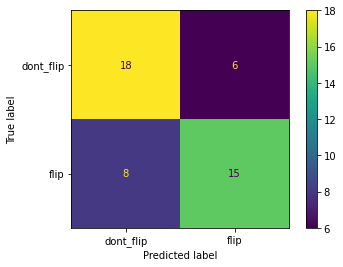

In [26]:
# Display the confusion matrix to evaluate the model

#what's that!??
#ohhhh okay, i get it now. look at the axes. so you're seeing how well the common labels lined up. i.e. where an image
#was both PREDICTED to be a flip AND was ACTUALLY a flip, as determined/stated by the label we gave it!
#so in time of writing this, it's showing, of the 102 test images, all 72 were categorized as flips were indeed labeled
#as flips. but actually,... EVERYTHING was labeled as a flip!!! so all 50 NOT FLIPS were ALSO labeled as flips!! it
#didn't label ANYTHING as a not flip!!! lol

cm = confusion_matrix(y_test, binary_values)
#so the y_test is now giving the ANSWER KEY so the algorithm can see how it did / its performance on this test/section
#so we gave the algo/machine this test set of images, combined flip and not flip so it didn't know which was which,
#all it had was the model it was trained on w/ the training set of images and corresponding labels. that was the
#instruction/guided section. this was its turn to do it on its own/try its hand at it
#so you see that it's actually very simple here, it's comparing the machine's answers, in 'binary_values', defined/
#assigned above, and comparing them to the CORRECT ANSWERS, as defined by us in y_test!!! confusion matrix is simply
#just a visual tool to help us see the performance w/ machine learning prediction performance
cmd = ConfusionMatrixDisplay(cm, display_labels=['dont_flip','flip'])
cmd.plot()

plt.show()

In [27]:
#after fixing the /255 scaling, of the 123 test images (72 flips & 51 dont flips) test images, it got almost all the
#dont flips right, but then also labeled the same number of flips as don't flip...

#after changing the image size to 32 x 32 and just cropping slightly to 28 x 28, jumped up to 63% accuracy
#it got a good chunk of the flips right, 58/72, but more than half of the DON'T flips wrong

#okay then i decided to focus on JUST kitchens to see if that would make thing better, but again lopsided results
#took care to trim out dataset to take out potentially confusing ones, although still had mix of semi-modern and
#modern modern. but it did really well w/ the non flips, but then also said not to flip most of the flips?
#so maybe i confused it w/ too many diff kinds of examples
#lol, this shows you how good of a teacher you are and also gives you insight into how a child's brain works...


#nice!! okay so after narrowing down types to make more consistent the model is performing much better and isn't so
#lopsided - now it's doing well over 50% for both flip & dont flip

#so next will probably be to continue to narrow/trim down to TYPES of kitchens, to get it superfocustrained on one/each
#type and also will prob need to get more images!

#hmm but then when i narrowed down further, it did even better for flips, but basically labeled EVERYTHING as a flip,
#so labeled most of the nonflips as flips

#so there could be several factors
#there's the varying number of flip training vs. not flip training - see what they did. well actually,
#ahmed/moustafa's experiment wasn't classification! so no categories to compare
#there were a few images of diff starting size - maybe threw it off
#there was that alpha/beta manipulation
#there's stuff ahmed/moustafa did w/ the images that maybe we didn't do here, or diff versions perhaps of same type of
#methods, like see their CNN function compared to vs our NN
#>>>>they do addl things like create an MLP, seems like they pretty much import the same packages from keras/tensorflow?
#and also diff VALUES used for same things, like how we saw w/ image size, but also like epochs - they did many more
#we might've overcomplicated the model by giving it pics of different rooms? maybe needa break it up?
#also there were only a few / one-off (not enough) images of nonflips of exterior without much training on that
#remem the training had alot of SEMI-modern images/examples for non-flips, and actually, some were flips,
#so might've confused it. so could be like we suspected, may have to pick one or other
#could be that there's other things that need to be checked, like where i altered stuff, such as taking out the axis=,etc, or like how i commented out the divide by 255!
#check out the messages w/ the model training/epoch part?
#there might be some differences w/ ahmed/moustafa since they were also using text. (how) did they tie both image & text
#training & testing together? and did they have to compare each room to each room when making a prediction, like apples
#to apples? or was that automatically figured out?
#>>>>OHH okay i see now as i look thru ahmed/moustafa's code that they PUT EVERY SET OF 4 IMAGES TOGETHER AS A SET!
#they make a 2x2 tile block and ensure they're in the same order / arrangement every time. so yeah may well be that we
#have to keep it as sets, maybe of 3 cuz as we said, don't care about exterior so much; can do that separately
#OR, can pick just ONE thing to start off w/ at first, like a kitchen, to determine if it's outdated or not

In [28]:
#what's the best way to see which images it identified as which, esp the wrong ones?

In [29]:
# Print the Classification report to get the precision, recall, f1-score

#whatre thoooooooose!?!? >> it's to simply see the performance/accuracy, based on different standards

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        24
           1       0.71      0.65      0.68        23

    accuracy                           0.70        47
   macro avg       0.70      0.70      0.70        47
weighted avg       0.70      0.70      0.70        47



### Conclusion

I was able to create a model with 0.__ accuracy for whether a page needs to be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the images black & white, all the same size, cropping them, adjusting brightness, adding noise, etc.

In [30]:
# Save the model using pickle

#doesn't say pickle anywhere??? we did import it at start/top tho

model_classifier = model.save('flip_page_classifier')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: flip_page_classifier/assets


2022-01-11 11:51:10.623271: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
